# Выбор локации для скважины

Мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

**Описание данных**

В нашем распоряжении три датасета с пробами нефти в трёх разных регионах. В данных имеется:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (к сожалению подробности о признаках нам не передали, но намекнули, что признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

In [1]:
import sklearn # Проверка версии sklearn. Обновляем при необходимости
if sklearn.__version__ == '0.24.1':
    !pip install scikit-learn -U # После установки надо перезапустить ядро
sklearn.__version__ 

'1.5.0'

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import numpy as np
from scipy import stats as st

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [3]:
sns.set(style='darkgrid', palette='deep') # Устанавливаем стиль для графиков
RANDOM_STATE = 42 # Константа определения случайных значений 

## Загрузка и подготовка данных

Для начала познакомимся с нашими данными.

In [4]:
def dataset_info(ds, info=True): # Универсальная функция презентации данных
    print('Количество дубликатов:', ds.duplicated().sum())
    print('Длина датасета:', len(ds))
    display(ds.head())
    if info: 
        ds.info()
        display(ds.describe())

In [5]:
try:
    ds_0 = pd.read_csv('/datasets/geo_data_0.csv', index_col='id')
except:
    ds_0 = pd.read_csv('datasets/geo_data_0.csv', index_col='id')
dataset_info(ds_0)

Количество дубликатов: 0
Длина датасета: 100000


,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [6]:
try:
    ds_1 = pd.read_csv('/datasets/geo_data_1.csv', index_col='id')
except:
    ds_1 = pd.read_csv('datasets/geo_data_1.csv', index_col='id')
dataset_info(ds_1)

Количество дубликатов: 0
Длина датасета: 100000


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [7]:
try:
    ds_2 = pd.read_csv('/datasets/geo_data_2.csv', index_col='id')
except:
    ds_2 = pd.read_csv('datasets/geo_data_2.csv', index_col='id')
dataset_info(ds_2)

Количество дубликатов: 0
Длина датасета: 100000


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Ни дубликатов, ни пропусков. Значение `product` ни в одном датасете не опускается ниже нуля, это важно. Выработка не может быть отрицательной, мы-же занимаемся скважинами, а не черными дырами.

Мимоходом взглянем на распределения значений.

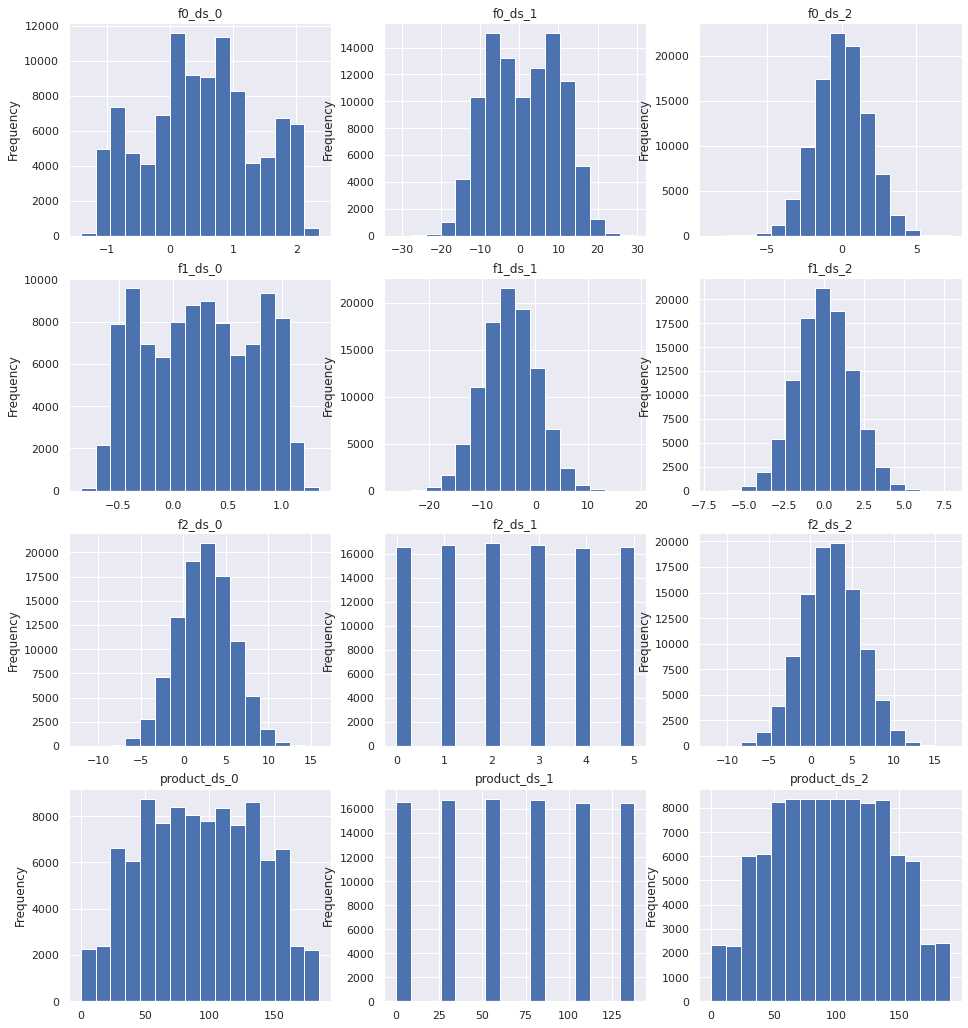

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 18))

for j, i in enumerate(ds_0.columns):
    for k, l in enumerate([ds_0, ds_1, ds_2]):
        l[i].plot(kind='hist', ax=axes[j, k], title=i+'_ds_'+str(k), bins=16)

Аномальных значений нет. Распределения значений сильно различаются в разных регионах. Признаки `f2` и `product` из ds_1 крайне смахивают на категориальные, однако в них всё-же занесены непрерывные данные. Похоже на ошибочное округление значений, но с этим уже ничего сделать не получится. Придётся использовать эти данные.

Все имеющиеся у нас данные, за исключением id - численные. Тут не обойтись без скейлера. Составим трансформер столбцов для препроцессинга данных.

In [9]:
data_preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), ['f0', 'f1', 'f2'])
])

## Обучение и проверка модели

Нам необходимо обучить 3 модели, по одной на каждый регион. Для обучения нам подойдёт только линейная регрессия, остальные недостаточно предсказуемы. 

In [10]:
lr_0 = Pipeline([ 
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression()) 
]) 
lr_1 = lr_0
lr_2 = lr_0 # В моделях различаться будут только данные, все методы одинаковы. Делаем 2 копии готового пайплайна.

Теперь необходимо разделить данные. Нам нужны обучающие и валидационные выборки в соотношении 75:25 для каждого датасета.

In [11]:
X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(ds_0.drop('product', axis=1), ds_0['product'], test_size=0.25, random_state=RANDOM_STATE)
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(ds_1.drop('product', axis=1), ds_1['product'], test_size=0.25, random_state=RANDOM_STATE)
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(ds_2.drop('product', axis=1), ds_2['product'], test_size=0.25, random_state=RANDOM_STATE)

Обучим модели, и сразу попросим сделать предсказания.

In [12]:
lr_0.fit(X_train_0, y_train_0)
lr_1.fit(X_train_1, y_train_1)
lr_2.fit(X_train_2, y_train_2)

y_pred_0 = lr_0.predict(X_valid_0)
y_pred_1 = lr_1.predict(X_valid_1)
y_pred_2 = lr_2.predict(X_valid_2)

Для вывода метрики, за которую мы возьмём RMSE - корень из среднего значения квадратов ошибок, создадим функцию, которая будет принимать истинные и предсказанные значения, а также номер региона, и будет выводить все необходимые нам данные.

In [13]:
def rmse_present(true, pred, region):
    print('Модель линейной регрессии для региона №'+str(region))
    print('RMSE модели:', root_mean_squared_error(true, pred).round(4))
    print('Средний запас предсказанного сырья:', pred.mean().round(4))
    print('')

Сделаем список списков с готовыми данными для расчёта метрик, чтобы не обращаться к функции каждый раз вручную. И запустим цикл, который пройдётся по каждому из трёх наборов данных.

In [14]:
rmse_data = [[y_valid_0, y_pred_0, 0], [y_valid_1, y_pred_1, 1], [y_valid_2, y_pred_2, 2]]

for i, j, k in rmse_data:
    rmse_present(i, j, k)

Модель линейной регрессии для региона №0
RMSE модели: 38.9361
Средний запас предсказанного сырья: 94.7658

Модель линейной регрессии для региона №1
RMSE модели: 44.591
Средний запас предсказанного сырья: 94.8542

Модель линейной регрессии для региона №2
RMSE модели: 40.1459
Средний запас предсказанного сырья: 94.771



Наилучший результат качества предсказаний показала модель для региона номер 0, однако этот-же регион показал самый низкий запас предсказанного сырья. Возможно здесь имеется закономерность, и остальные модели немного завышают результаты предсказаний.

## Подготовка к расчёту прибыли

Для начала сохраним ключевые значения для расчётов в отдельные переменные.

In [15]:
scouting_count = 500 # При разведке региона исследуют данное количество точек
scouting_best = 200 # Среди них с помощью МО выбирают данное количество лучших для разработки
budget = 10000000000 # Бюджет на разработку скважин в регионе, рублей
income = 450000 # Прибыль с одной единицы продукта, рублей
loss_risk = .025 # Порог вероятности убытков. После оценки рисков выбираются только регионы, в которых вероятность убытков меньше порога

Теперь рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Поделим бюджет на прибыль с одной единицы продукта, а после на планируемое количество скважин для разработки. И получим количество единиц продукта, которое каждая скважина должна содержать, чтобы компания не работала себе в убыток.

In [16]:
payback = round(budget/income/scouting_best, 2)
payback

111.11

111 тысяч баррелей, столько должна содержать скважина, чтобы окупить свою разработку. Это больше средних предсказанных запасов каждого из трёх регионов на 15-16 тысяч баррелей. Далеко не каждая скважина нам подойдёт, но именно за этим мы здесь и собрались.

## Расчёт прибыли и рисков 

In [17]:
state = np.random.RandomState(RANDOM_STATE) # Определение случайных значений для бутстрепа

Теперь приступим к самому приятному - будем считать прибыль. Пока только теоретическую. Для этого создадим функцию. 

Она будет принимать на вход спрогнозированные значения, отбирать из них заданное количество лучших(`scouting_best`), и рассчитывать прибыль по формуле `общий объём сырья` * `прибыль с единицы` - `бюджет на разработку скважин`

In [18]:
def profit_check(data):
    data = data.sort_values(by=0, ascending=False)
    data = data.head(scouting_best)
    capacity = data.sum()
    return float(capacity*income-budget)

Функция готова, теперь бутстреп. Напомню, бутстреп - это техника, при которой имеющиеся данные разбиваются на случайные подвыборки, с которыми уже и производятся вычисления. Мы можем разбивать данные сколько душе угодно, но за основу возьмём 1000 итераций для каждого региона. Итого мы 1000 раз возьмём случайные записи в количестве `scouting_count` из трёх генеральных совокупностей. Эти записи будут имитировать разведанные в регионе скважины, и в каждой итерации мы будем рассчитывать прибыль, которую мы с них получим. Все результаты прибыли мы занесём в список, и позже получим доверительные интервалы, средние значения и риски отрицательной прибыли. Теория есть, приступим к практике.

In [19]:
def bootstrap_check(ds, region):
    incomes = []
    for i in range(1000):
        incomes.append(profit_check(ds.sample(scouting_count, replace=False, random_state=state)))
    incomes = pd.Series(incomes)
    print('Данные по региону №'+str(region))
    print('Средняя прибыль в регионе:', np.mean(incomes))
    print('95%-й доверительный интервал:', st.t.interval(.95, df=len(incomes)-1, loc=np.mean(incomes), scale=np.std(incomes)))
    print('Риск убытков:', (incomes<0).sum()/len(incomes)*100, '%')
    if (incomes<0).sum()/len(incomes)<loss_risk:
        print('Риск убытков проходит по порогу')
    else:
        print('Риск убытков слишком велик, регион бесперспективен')
    print('')
    return incomes

In [20]:
incomes_0 = bootstrap_check(pd.DataFrame(y_pred_0, index=X_valid_0.index), 0) # На текущий момент нет необходимости получать айди отдельных скважин. Но на случай если это понадобится в будущем - предсказанные значения передаются с привязкой по айди в виде индекса
incomes_1 = bootstrap_check(pd.DataFrame(y_pred_1, index=X_valid_1.index), 1)
incomes_2 = bootstrap_check(pd.DataFrame(y_pred_2, index=X_valid_2.index), 2)

Данные по региону №0
Средняя прибыль в регионе: 146937500.63264123
95%-й доверительный интервал: (-26924852.435116768, 320799853.7003992)
Риск убытков: 5.3 %
Риск убытков слишком велик, регион бесперспективен

Данные по региону №1
Средняя прибыль в регионе: -549587779.651768
95%-й доверительный интервал: (-635159249.6304497, -464016309.6730863)
Риск убытков: 100.0 %
Риск убытков слишком велик, регион бесперспективен

Данные по региону №2
Средняя прибыль в регионе: 267772069.57956654
95%-й доверительный интервал: (69923037.24982992, 465621101.9093032)
Риск убытков: 0.3 %
Риск убытков проходит по порогу



Регион 1 показал наихудший результат. 100% убытков, нет никакого шанса, что наши вложения в нём окупятся. Его мы можем сразу отбросить.

Регион 0 продемонстрировал результат значительно лучше, но риски уйти в минус всё равно слишком велики.

Регион 2 единственный проходит по порогу риска убытков, а также показывает наибольшее среднее значение прогнозной прибыли, и может считаться самым перспективным для разработки новых скважин. Именно его мы и предложим.

## Итоговый вывод

В рамках загрузки и подготовки данных, мы:
- Проверили данные на пропуски и дубликаты;
- Проследили за распределением значений, убедились в отсутствии аномалий;
- Составили заготовку препроцессинга для пайплайнов моделей.

В рамках обучения моделей и проверки качества, мы:
- Составили пайплайны для трёх моделей;
- Обучили три линейные регрессии в пайплайне, на датасетах разных регионов;
- Рассчитали средние значения предсказанного сырья для каждой модели;
- Вывели метрики RMSE для каждой модели.

В рамках подготовки к расчёту прибыли, мы:
- Сохранили ключевые значения для расчётов в переменные. Это позволит легко модифицировать модель при изменении условий работы;
- Рассчитали минимальный объём содержания сырья в каждой скважине, необходимое для её окупаемости.

В рамках расчёта прибыли и рисков, мы:
- Написали функцию для расчёта прибыли по прогнозированным значениям содержания сырья;
- Провели 1000 итераций по технике бутстреп для каждого региона и расчитали итоговую прибыль для каждой подвыборки;
- По полученным значениям расчитали доверительные интервалы, среднюю прибыль в регионе и риски убытков;
- Сделали выводы по перспективности регионов.

Самым перспективным регионом для разработки скважин, на основе средней прогнозной прибыли, доверительного интервала прогнозных значений и риска убытков, был выбран регион №2.

Рекомендации заказчику: 
- Сократить активность компании в регионе №1, показавшем риск убытков 100% и отрицательную среднюю прибыль;
- Повысить активность в регионе №2.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Выполнен шаг 1: данные подготовлены
- [X]  Выполнен шаг 2: модели обучены и проверены
    - [X]  Данные корректно разбиты на обучающую и валидационную выборки
    - [X]  Модели обучены, предсказания сделаны
    - [X]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [X]  На экране напечатаны результаты
    - [X]  Сделаны выводы
- [X]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [X]  Для всех ключевых значений созданы константы Python
    - [X]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [X]  По предыдущему пункту сделаны выводы
    - [X]  Написана функция расчёта прибыли
- [X]  Выполнен шаг 4: посчитаны риски и прибыль
    - [X]  Проведена процедура *Bootstrap*
    - [X]  Все параметры бутстрепа соответствуют условию
    - [X]  Найдены все нужные величины
    - [X]  Предложен регион для разработки месторождения
    - [X]  Выбор региона обоснован